## Modelling for BME - Forward problem modelisation
### Practice 1
### Student: Eduardo Osquel Perez Rivero

In [ ]:
!pip install numpy pmcx jdata bjdata matplotlib

import numpy as np
import pmcx
import jdata as jd
from matplotlib import pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse import linalg

pmcx.__version__   # print imported pmcx version number

pmcx.gpuinfo()

[{'name': 'Tesla T4',
  'id': 1,
  'devcount': 1,
  'major': 7,
  'minor': 5,
  'globalmem': 15835660288,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1590000,
  'sm': 40,
  'core': 2560,
  'autoblock': 64,
  'autothread': 81920,
  'maxgate': 0}]

nphoton: 1e+06
tstart: 0
tstep: 5e-09
tend: 5e-09


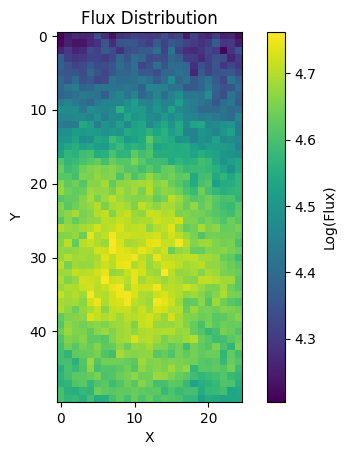

In [ ]:
# OPTICAL PROPERTIES
n        = 1.37       # Index of refraction [-]
g        = 0.9        # Anisotropy [-]
mua      = 0.1        # Absorption coeff. [cm^-1]
mus      = 100        # Scattering coeff  [cm^-1]
musprime = (1-g)*mus  # Reduce Scattering coeff [cm^-1]
D        = 1.0/(3*(mua + musprime)) # Diffusion coeff. [cm]
mueff    = np.sqrt(mua/D)  # exp decay rate of fluence far from the source [cm^-1]


# GEOMETRY FOR DIFFUSION EQUATION
Lx = 4.0 # slab length [cm]
Ly = 4.0 # slab width [cm]
Lz = 2.0 # slab depth

nx = 50 # number of pixels in x-dir [-]
ny = 50 # number of pixels in y-dir [-]
nz = 25 # number of pixels in z-dir [-]

dx = Lx/nx # pixel size in x-dir [cm]
dy = Ly/ny # pixel size in y-dir [cm]
dz = Lz/nz # pixel size in z-dir [cm]

# BOUNDARY CONDITION
#   - Refracitive-Index-Matched Boundary
#   - Extrapolated boudary condition
zb = 2*D

# BUILD MESH FOR ED
LxMesh = Lx + 2*(zb+dx)
LyMesh = Ly + 2*(zb+dy)
LzMesh = Lz + 2*(zb+dz)

xMeshAxis = np.arange(0,LxMesh,dx)
yMeshAxis = np.arange(0,LyMesh,dy)
zMeshAxis = np.arange(0,LzMesh,dz)

# mesh convention:
#   - domain          :: 1
#   - extended domain :: 2
#   - boundary        :: 3
mesh = np.ones( ( len(xMeshAxis), len(yMeshAxis), len(zMeshAxis) ) )

# label extended areas
xStartDomainIdx = np.argwhere(xMeshAxis>=2*D)[0][0]
yStartDomainIdx = np.argwhere(yMeshAxis>=2*D)[0][0]
zStartDomainIdx = np.argwhere(zMeshAxis>=2*D)[0][0]
mesh[1:xStartDomainIdx,:,:] = 2
mesh[:,1:yStartDomainIdx,:] = 2
mesh[:,:,1:zStartDomainIdx] = 2
xStopDomainIdx = np.argwhere(xMeshAxis>=Lx+2*D)[0][0]
yStopDomainIdx = np.argwhere(yMeshAxis>=Ly+2*D)[0][0]
zStopDomainIdx = np.argwhere(zMeshAxis>=Lz+2*D)[0][0]
mesh[xStopDomainIdx:,:,:] = 2
mesh[:,yStopDomainIdx:,:] = 2
mesh[:,:,zStopDomainIdx:] = 2

# label mesh boundaries
mesh[0,:,:] = 3
mesh[:,0,:] = 3
mesh[:,:,0] = 3
mesh[-1,:,:] = 3
mesh[:,-1,:] = 3
mesh[:,:,-1] = 3


###############################################################################
# build here the M matrix
#

nb_of_voxel = len(mesh.ravel())
nb_of_voxel = mesh.shape[0] * mesh.shape[1] * mesh.shape[2]
M = lil_matrix((nb_of_voxel, nb_of_voxel))
b = lil_matrix((nb_of_voxel, 1))

# Fill matrix M
for i in range(mesh.shape[0]):
    for j in range(mesh.shape[1]):
        for k in range(mesh.shape[2]):
            idx = np.ravel_multi_index((i, j, k), mesh.shape)
            if mesh[i, j, k] == 3:  # Boundary
                M[idx, idx] = 1
            else:  # Domain
                M[idx, idx] = -2/dx**2 -2/dy**2 -2/dz**2 - mua/D
                idx_right = np.ravel_multi_index((i + 1, j, k), mesh.shape)
                idx_left = np.ravel_multi_index((i - 1, j, k), mesh.shape)
                idx_top = np.ravel_multi_index((i, j + 1, k), mesh.shape)
                idx_bottom = np.ravel_multi_index((i, j - 1, k), mesh.shape)
                idx_front = np.ravel_multi_index((i, j, k + 1), mesh.shape)
                idx_back = np.ravel_multi_index((i, j, k - 1), mesh.shape)
                M[idx, idx_right] = 1 / dx**2
                M[idx, idx_left] = 1 / dx**2
                M[idx, idx_top] = 1 / dy**2
                M[idx, idx_bottom] = 1 / dy**2
                M[idx, idx_front] = 1 / dz**2
                M[idx, idx_back] = 1 / dz**2

# Fill matrix b
# Convert source to a sparse matrix

source_idx = np.ravel_multi_index((mesh.shape[0] // 2, mesh.shape[1] // 2, mesh.shape[2] // 2), mesh.shape)

b[source_idx] = -1/D

# INVERSE FINITE DIFFERENCE SYSTEM
M = M.tocsc()
b = b.tocsc()
fluence_ED = linalg.spsolve(M, b)

# reshape here fluence vector to get a volume
fluence_ED_cube = np.reshape(fluence_ED, mesh.shape)

#CALCUL MONTE CARLO

cfg = {
       'nphoton': 1e6,
       'vol': np.ones([50,50,25], dtype='uint8'),  # Use the updated object_vol with the sphere
       'tstart': 0,
       'tend': 5e-9,
       'tstep': 5e-9,
       'srcpos': [25, 25, 12],
       'srcdir': [1, 0, 0],
       'prop': [[0, 0, 1, 1], [0.005, 0.1, 0.01, 1.37], [mua, 10, g, mus]]  # Include optical properties for label 2 (sphere)
       }

# Run the Monte Carlo simulation
res = pmcx.run(cfg)
fluence_MC = res['flux']


# Visualize results here

# Plot the result (flux) after the simulation
plt.figure(figsize=(15, 9))

plt.imshow(np.log10(res['flux'][:, 49, :]))
#plt.imshow(np.log10(res['flux'][25, :, :, 0]))
plt.colorbar(label='Log(Flux)')
plt.title('Flux Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#plt.imshow(fluence_ED_cube[:,:,14])
#plt.imshow(fluence_ED_cube[:,:,7])
#plt.imshow(fluence_ED_cube[:,:,4])